In [12]:
import os
import PIL
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.utils import make_grid, save_image
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import resnet as RN

from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp
import matplotlib.pyplot as plt
from PIL import Image 
import PIL 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

import numpy as np
import tensorflow as tf
# from tensorflow import keras
import os
import random
import json

from tensorflow.keras.models import load_model

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# from config import tiny_imagenet_config as myconfig
# from pipeline.preprocessing import ImageToArrayPreprocessor
# from pipeline.preprocessing import SimplePreprocessor
# from pipeline.preprocessing import MeanPreprocessor
# from pipeline.utils.ranked import rank5_accuracy
# from pipeline.io import HDF5DatasetGenerator
# from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array


In [13]:
dataset = 'tinyimagenet'
depth = 50
pretrained_vanilla = 'runs/tin/resnet50/vanilla/model_best.pth.tar'
pretrained_clewr = 'runs/tin/resnet50/curr_exp/model_best.pth.tar'
view_layer = 'module_layer3'
numberofclass = 200
out_dir = 'cams/tin/resnet50'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# Load model

In [14]:
# Load vanilla model
model1 = RN.ResNet(dataset=dataset, depth=depth, num_classes=numberofclass, bottleneck=True) 
model1 = torch.nn.DataParallel(model1)

print("=> loading checkpoint '{}'".format(pretrained_vanilla))
# checkpoint = torch.load(pretrained_vanilla, map_location=torch.device('cpu') )
checkpoint = torch.load(pretrained_vanilla)
model1.load_state_dict(checkpoint['state_dict'], strict=False)
print("=> loaded checkpoint '{}'".format(pretrained_vanilla))

# print(model)
print('the number of model parameters: {}'.format(sum([p.data.nelement() for p in model1.parameters()])))
model1.to(device).eval()


=> loading checkpoint 'runs/tin/resnet50/vanilla/model_best.pth.tar'
=> loaded checkpoint 'runs/tin/resnet50/vanilla/model_best.pth.tar'
the number of model parameters: 23917832


DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [15]:
# Load clewr model
model2 = RN.ResNet(dataset=dataset, depth=depth, num_classes=numberofclass, bottleneck=True) 
model2 = torch.nn.DataParallel(model2)

print("=> loading checkpoint '{}'".format(pretrained_clewr))
# checkpoint = torch.load(pretrained_clewr, map_location=torch.device('cpu') )
checkpoint = torch.load(pretrained_clewr)
model2.load_state_dict(checkpoint['state_dict'], strict=False)
print("=> loaded checkpoint '{}'".format(pretrained_clewr))

print('the number of model parameters: {}'.format(sum([p.data.nelement() for p in model2.parameters()])))
model2.to(device).eval()

=> loading checkpoint 'runs/tin/resnet50/curr_exp/model_best.pth.tar'
=> loaded checkpoint 'runs/tin/resnet50/curr_exp/model_best.pth.tar'
the number of model parameters: 23917832


DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [16]:
configs1 = [dict(model_type='densenet', arch=model1, layer_name=view_layer)]
configs2 = [dict(model_type='densenet', arch=model2, layer_name=view_layer)]

# gradcam = GradCAM.from_config(model_type='resnet', arch=model, layer_name='layer3')
cams1 = [
    [cls.from_config(**config) for cls in (GradCAM, GradCAMpp)]
    for config in configs1
]
cams2 = [
    [cls.from_config(**config) for cls in (GradCAM, GradCAMpp)]
    for config in configs2
]

# Load dataset

In [17]:
if dataset == 'tinyimagenet':
    data_dir = '../datasets/tiny-imagenet-200/'
    val_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262])
            ])
    val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val_labeled'), val_transforms) 

    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=True)
    numberofclass = 200
    mean = [0.4802, 0.4481, 0.3975]
    std = [0.2302, 0.2265, 0.2262]
it = iter(val_loader)


# Calculate Grad-CAM

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


18 168 168
7 56 52


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


42 137 43
66 4 66


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


123 123 123


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


58 58 58


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


142 32 97
42 42 42


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


166 166 166


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


111 84 111


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


90 90 90


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


59 180 123
166 166 166


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


118 118 118


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


119 84 84
34 48 11


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


151 176 113
166 166 166


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


88 88 88


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


90 163 111
85 105 105


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


54 54 54


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


158 158 158


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


145 145 145


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 46 190
150 150 150


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 2 2
99 180 81


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


197 198 198
69 83 167


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


40 40 7
34 30 164


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


189 189 65
134 90 134


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


141 141 140
165 165 165


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


135 97 61
184 187 187


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


89 89 89


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


173 113 173


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


106 109 106


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


118 118 118


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


155 155 155


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


30 31 30


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


137 137 137


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


158 158 158


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


53 53 52
5 10 10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


129 185 44
136 136 136


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


109 193 109


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


150 165 150


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


12 12 12


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


157 195 195
105 105 105


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


80 136 136
42 42 42


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


69 140 140
116 116 116


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


25 25 25


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


59 188 144
77 77 75


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


37 37 37


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


136 136 83
138 147 138


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


79 79 160
34 34 34


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


134 188 80
190 190 190


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


65 167 65


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


46 134 154
102 102 102


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


178 178 178


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 1 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


59 59 59


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


102 83 0
9 98 98


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


116 49 49
61 61 61


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


120 160 184
118 118 118


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 0 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


52 52 52


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


190 15 190


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


23 23 23


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 6 6


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


145 151 145


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


92 86 86
88 88 116


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


77 77 77


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


66 66 129
194 84 84


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


53 53 53


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


27 26 26
169 62 163


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


70 94 94
147 59 59


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


112 112 112


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


41 177 84
196 196 196


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


20 20 20


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


120 120 120


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


75 66 157
39 39 43


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


127 127 127


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


110 110 110


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


136 136 136


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


128 138 110
39 164 39


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


183 183 183


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


73 130 73


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


118 113 175
21 21 21


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


51 51 52
13 13 13


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


142 142 59
170 163 163


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


60 29 29
101 101 101


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


169 169 169


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


126 61 165
153 153 153


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


36 36 36


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 30 3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


117 131 20
34 26 56


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


78 78 78


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


159 73 137
140 140 140


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


124 124 124


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 5 5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


161 161 29
54 58 49


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


58 12 58


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


193 193 193


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


192 192 192


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


85 85 85


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


148 55 132
119 167 119


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


31 31 31


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


23 23 23


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


44 44 44


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


127 79 79
26 26 26


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10 10 10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


44 44 44


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


51 9 48
168 167 81


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


69 109 42
106 87 69


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


61 61 61


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


99 124 124
6 6 6


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


132 132 99
181 181 181


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


183 183 183


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


18 59 18


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


152 92 141
7 13 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


178 178 178


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


179 177 177
135 149 109


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


95 132 78
56 51 157


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


45 39 38
130 188 104


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


96 198 198
51 34 34


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


37 8 8
58 58 58


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


60 60 60


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


49 57 84
70 156 153


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


182 179 179
72 130 72


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


127 69 127


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


192 187 187
156 156 77


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


40 168 109
130 130 130


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


97 97 140
189 184 189


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15 100 122
52 52 52


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


26 35 46
191 41 10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


144 144 112
190 191 190


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


42 184 40
143 143 143


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 6 6


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


90 149 138
11 86 86


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


39 39 39


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 89 24
72 172 72


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


142 160 17
47 47 31


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


170 170 167
158 83 117


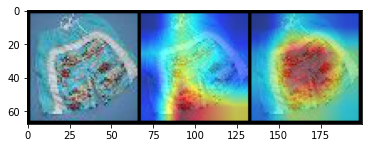

In [18]:

for i in range(200):
    images = []
    torch_img, target = it.next()
    img_np = torch_img.numpy()[0]
    img_np = np.swapaxes(img_np, 0, 2)
    img_np = np.swapaxes(img_np, 0, 1)
    a = (img_np - img_np.min())
    a = a/a.max()
    a = np.swapaxes(a, 0, 2)
    a = np.swapaxes(a, 1, 2)
    original_image = torch.tensor(a)
    img_arr = [original_image.cpu()]

    target = target.numpy()[0]

    logits = []
    for gradcam, gradcam_pp in cams1:
        mask, logit = gradcam(torch_img, target)
        heatmap, result = visualize_cam(mask, torch_img)

        mask_pp, _ = gradcam_pp(torch_img, target)
        heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)
        
        result_f = (3*heatmap_pp/5 + original_image/2 )
        
        img_arr.extend([result_f])
        
        logit = np.argmax(logit.cpu().detach().numpy(), -1)[0]
        logits.extend([logit])
        
    for gradcam, gradcam_pp in cams2:
        mask, logit = gradcam(torch_img, target)
        heatmap, result = visualize_cam(mask, torch_img)

        mask_pp, _ = gradcam_pp(torch_img, target)
        heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)
        
        result_f = (heatmap_pp/2 + original_image/2 )
        
        img_arr.extend([result_f])
        
        logit = np.argmax(logit.cpu().detach().numpy(), -1)[0]
        logits.extend([logit])
        
    images.extend(img_arr)
    print(target, logits[0], logits[1])
    grid_image = make_grid(images, nrow=3)
    grid_img = grid_image.numpy()
    grid_img = np.swapaxes(grid_img, 0, 2)
    grid_img = np.swapaxes(grid_img, 0, 1)
    plt.imshow(grid_img)
    if(logits[1] == target):  # if clewr gives correct prediction
        if(target == logits[0]):  # if vanilla also gives correct prediction
            plt.savefig(out_dir + "/allsame" + str(target) + "-" + str(logits[0]) + "-" + str(logits[1]) + "  " +str(i))
        else:
            plt.savefig(out_dir + "/clewr" + str(target) + "-" + str(logits[0]) + "-" + str(logits[1]) + "  " +str(i))
#     else:
#         plt.savefig('../TinyImagenet-Resnet-Gradcams/' + "notclewr" + str(target) + "-" + str(logits[0]) + "-" + str(logits[1]) + "  " +str(i))
#     plt.savefig('../TinyImagenet-Resnet-Gradcams/' + str(target) + "-" + str(logits[0]) + "-" + str(logits[1]) + "  " +str(i))
    
# plt.show()

# Corrupted Data Analysis


In [19]:
# corrupted_data_dir = '../data/CIFAR-10-C'
distortion_string = ["brightness" , 'contrast' , 'defocus_blur' , 'elastic_transform'  , 'fog' , 'frost'  , 'gaussian_noise', 'glass_blur' , 'impulse_noise' , 'jpeg_compression','motion_blur','pixelate', 'shot_noise' , 'snow', 'zoom_blur']


In [20]:
# for x  in distortion_string:
#     os.mkdir('../TinyImagenet-Resnet-Gradcams-Corrupted/' + x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


brightness


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

contrast


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

defocus_blur


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

elastic_transform


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

fog


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

frost


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

gaussian_noise


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

glass_blur


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

impulse_noise


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

jpeg_compression


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

motion_blur


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

pixelate


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

shot_noise


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

snow


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

zoom_blur


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

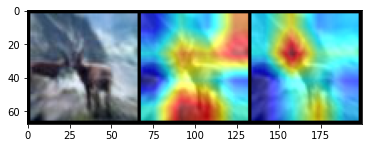

In [21]:
for distortion_name in  distortion_string : 
    severity = 3
    data_dir = '../datasets/Tiny-ImageNet-C/' + distortion_name + '/' + str(severity) + '/'
    val_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262])
            ])
    val_dataset = datasets.ImageFolder(os.path.join(data_dir), val_transforms) 

    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=True)
    numberofclass = 200
    mean = [0.4802, 0.4481, 0.3975]
    std = [0.2302, 0.2265, 0.2262]
    it = iter(val_loader)
    print(distortion_name)
    
    for i in range(50):
        images = []
        torch_img, target = it.next()
        img_np = torch_img.numpy()[0]
        img_np = np.swapaxes(img_np, 0, 2)
        img_np = np.swapaxes(img_np, 0, 1)
        a = (img_np - img_np.min())
        a = a/a.max()
        a = np.swapaxes(a, 0, 2)
        a = np.swapaxes(a, 1, 2)
        original_image = torch.tensor(a)
        img_arr = [original_image.cpu()]

        target = target.numpy()[0]

        logits = []
        for gradcam, gradcam_pp in cams1:
            mask, logit = gradcam(torch_img, target)
            heatmap, result = visualize_cam(mask, torch_img)

            mask_pp, _ = gradcam_pp(torch_img, target)
            heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)

            result_f = (2*heatmap_pp/3 + original_image/2 )

            img_arr.extend([result_f])

            logit = np.argmax(logit.cpu().detach().numpy(), -1)[0]
            logits.extend([logit])
        for gradcam, gradcam_pp in cams2:
            mask, logit = gradcam(torch_img, target)
            heatmap, result = visualize_cam(mask, torch_img)

            mask_pp, _ = gradcam_pp(torch_img, target)
            heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)

            result_f = (2*heatmap_pp/3 + original_image/2 )

            img_arr.extend([result_f])

            logit = np.argmax(logit.cpu().detach().numpy(), -1)[0]
            logits.extend([logit])

        images.extend(img_arr)
#         print(target, logits[0], logits[1])
        grid_image = make_grid(images, nrow=3)
        grid_img = grid_image.numpy()
        grid_img = np.swapaxes(grid_img, 0, 2)
        grid_img = np.swapaxes(grid_img, 0, 1)
        plt.imshow(grid_img)
        out_dir = f'cams/tin/resnet50/{distortion_name}'
        if not os.path.exists(out_dir):
            os.makedirs(out_dir)
        if(logits[1] == target):
            if(target == logits[0]):
                pass
                # plt.savefig('../TinyImagenet-Resnet-Gradcams-Corrupted/' + distortion_name + "/allsame" + str(target) + "-" + str(logits[0]) + "-" + str(logits[1]) + "  " +str(i))
            else:
                plt.savefig(out_dir + "/clewr" + str(target) + "-" + str(logits[0]) + "-" + str(logits[1]) + "  " +str(i))


In [22]:
# from PIL import Image 
# import PIL 

In [23]:
# grid_img = grid_image.numpy()
# grid_img = np.swapaxes(grid_img, 0, 2)
# grid_img = np.swapaxes(grid_img, 0, 1)
# plt.imshow(grid_img)

In [24]:
# transforms.ToPILImage()(grid_image)